# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

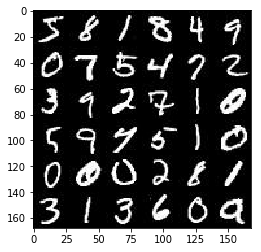

In [2]:
show_n_images = 37

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

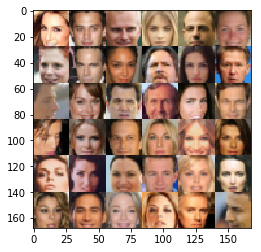

In [3]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs = tf.placeholder(tf.float32,(None, z_dim), name='z_inputs')
    learning_rate = tf.placeholder(tf.int32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: slope of leak for ReLU
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Convolve images from 28x28x3 to 14x14x64
        c1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        c1 = tf.maximum(alpha * c1, c1)
        
        # Convolve images to 7x7x128
        c2 = tf.layers.conv2d(c1, 128, 5, strides=2, padding='same')
        c2 = tf.layers.batch_normalization(c2, training=True)
        c2 = tf.maximum(alpha * c2, c2)
        
        # Convolve images to 4x4x256
        c3 = tf.layers.conv2d(c2, 256, 5, strides=2, padding='same')
        c3 = tf.layers.batch_normalization(c3, training=True)
        c3 = tf.maximum(alpha * c3, c3)
        
        flatten = tf.reshape(c3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
                
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param alpha: slope of leak for ReLU
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not(is_train)):
        # NB. As per this DCGAN paper: https://arxiv.org/pdf/1511.06434.pdf, I also get better
        # results using relu with the generator convolutions
        
        # Start with fully connected layer
        fc1 = tf.layers.dense(z, 4*4*512)
        # Reshape to 4x4x512
        c1 = tf.reshape(fc1, (-1, 4, 4, 512))
        c1 = tf.layers.batch_normalization(c1, training=is_train)
        c1 = tf.nn.relu(c1)
        #c1 = tf.maximum(alpha * c1, c1)
                
        # Convolve to 7x7x256 now 
        c2 = tf.layers.conv2d_transpose(c1, 256, 4, strides=1, padding='valid')
        c2 = tf.layers.batch_normalization(c2, training=is_train)
        c2 = tf.nn.relu(c2)
        #c2 = tf.maximum(alpha * c2, c2)
                
        # Convolve to 14x14x128 now 
        c3 = tf.layers.conv2d_transpose(c2, 128, 5, strides=2, padding='same')
        c3 = tf.layers.batch_normalization(c3, training=is_train)
        c3 = tf.nn.relu(c3)
        #c3 = tf.maximum(alpha * c3, c3)
                
        # Output layer - final size 28x28x3
        logits = tf.layers.conv2d_transpose(c3, out_channel_dim, 5, strides=2, padding='same')
        
        
        output = tf.tanh(logits)
                
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :param alpha: slope of leak for ReLU
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim, alpha=alpha)
    real_d_model, real_d_logits = discriminator(input_real, alpha=alpha)
    fake_d_model, fake_d_logits = discriminator(gen_model, reuse=True, alpha=alpha)
    
    real_d_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=real_d_logits, labels=tf.ones_like(real_d_model)))
    fake_d_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_d_logits, labels=tf.zeros_like(real_d_model)))
    
    dis_loss = real_d_loss + fake_d_loss
    
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_d_logits, labels=tf.ones_like(fake_d_model)))
    
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Separate the generator and discriminator variables
    trainable_vars = tf.trainable_variables()
    gen_vars = [x for x in trainable_vars if x.name.startswith('generator')]
    dis_vars = [x for x in trainable_vars if x.name.startswith('discriminator')]
    
    # build optimisation functions
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        gen_optimiser = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        dis_optimiser = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
    
    
    return dis_optimiser, gen_optimiser


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False, alpha=0.2),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    :param alpha: slope of leak for ReLU
    """
    # Build Model
    real_inputs, z_inputs, lr = model_inputs(data_shape[1],
                                             data_shape[2],
                                             data_shape[3],
                                             z_dim)
    
    out_channels = len(data_image_mode)  # RGB=3; L=1
    dis_loss, gen_loss = model_loss(real_inputs, z_inputs, out_channels, alpha)
    
    dis_optimiser, gen_optimiser = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_count, batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model
                
                batch_images *= 2  # Scale image values back up between -1 and 1
                # Seed the 'fake' batch with noise
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                                
                # Optimise
                d_feed_dict = {real_inputs: batch_images, z_inputs: z_batch, lr: learning_rate}
                g_feed_dict = {real_inputs: batch_images, z_inputs: z_batch, lr: learning_rate}
                _ = sess.run(dis_optimiser, feed_dict=d_feed_dict)
                _ = sess.run(gen_optimiser, feed_dict=g_feed_dict)
                                
                # Output stats every 10 batches
                if batch_count % 10 == 0:
                    train_loss_d = dis_loss.eval({z_inputs: z_batch, real_inputs: batch_images})
                    train_loss_g = gen_loss.eval({z_inputs: z_batch})
                    print("Epoch {}/{};  ".format(epoch_i+1, epochs),
                          "Batch: {};  ".format(batch_count),
                          "Discriminator Loss: {:.4f};  ".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                # Show images every 100 batches
                if batch_count % 100 == 0:
                    show_generator_output(sess, 36, z_inputs, out_channels, data_image_mode)
                   
        # Show final image
        show_generator_output(sess, 36, z_inputs, out_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2;   Batch: 0;   Discriminator Loss: 29.9234;   Generator Loss: 0.0000


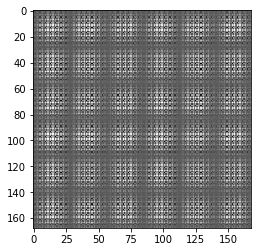

Epoch 1/2;   Batch: 10;   Discriminator Loss: 3.2051;   Generator Loss: 0.0489
Epoch 1/2;   Batch: 20;   Discriminator Loss: 0.0363;   Generator Loss: 4.9289
Epoch 1/2;   Batch: 30;   Discriminator Loss: 0.6134;   Generator Loss: 2.9254
Epoch 1/2;   Batch: 40;   Discriminator Loss: 0.6109;   Generator Loss: 11.1828
Epoch 1/2;   Batch: 50;   Discriminator Loss: 0.4156;   Generator Loss: 8.8497
Epoch 1/2;   Batch: 60;   Discriminator Loss: 0.0645;   Generator Loss: 3.3504
Epoch 1/2;   Batch: 70;   Discriminator Loss: 0.0378;   Generator Loss: 9.9567
Epoch 1/2;   Batch: 80;   Discriminator Loss: 3.8190;   Generator Loss: 8.1912
Epoch 1/2;   Batch: 90;   Discriminator Loss: 0.2245;   Generator Loss: 3.8542
Epoch 1/2;   Batch: 100;   Discriminator Loss: 0.2176;   Generator Loss: 2.2959


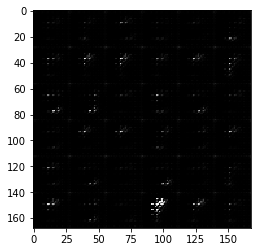

Epoch 1/2;   Batch: 110;   Discriminator Loss: 0.2593;   Generator Loss: 2.8755
Epoch 1/2;   Batch: 120;   Discriminator Loss: 1.7587;   Generator Loss: 0.5629
Epoch 1/2;   Batch: 130;   Discriminator Loss: 0.1455;   Generator Loss: 3.4941
Epoch 1/2;   Batch: 140;   Discriminator Loss: 0.4676;   Generator Loss: 1.6571
Epoch 1/2;   Batch: 150;   Discriminator Loss: 0.4506;   Generator Loss: 2.2583
Epoch 1/2;   Batch: 160;   Discriminator Loss: 0.8390;   Generator Loss: 0.9669
Epoch 1/2;   Batch: 170;   Discriminator Loss: 0.6900;   Generator Loss: 1.3300
Epoch 1/2;   Batch: 180;   Discriminator Loss: 0.6214;   Generator Loss: 1.8121
Epoch 1/2;   Batch: 190;   Discriminator Loss: 1.6497;   Generator Loss: 0.3920
Epoch 1/2;   Batch: 200;   Discriminator Loss: 1.7430;   Generator Loss: 0.3551


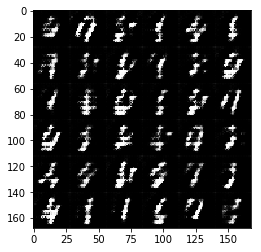

Epoch 1/2;   Batch: 210;   Discriminator Loss: 1.2069;   Generator Loss: 3.1241
Epoch 1/2;   Batch: 220;   Discriminator Loss: 1.1002;   Generator Loss: 1.3097
Epoch 1/2;   Batch: 230;   Discriminator Loss: 1.5179;   Generator Loss: 0.8418
Epoch 1/2;   Batch: 240;   Discriminator Loss: 0.4202;   Generator Loss: 1.6561
Epoch 1/2;   Batch: 250;   Discriminator Loss: 0.9622;   Generator Loss: 0.9074
Epoch 1/2;   Batch: 260;   Discriminator Loss: 0.6525;   Generator Loss: 1.2892
Epoch 1/2;   Batch: 270;   Discriminator Loss: 1.2313;   Generator Loss: 0.5662
Epoch 1/2;   Batch: 280;   Discriminator Loss: 0.9631;   Generator Loss: 0.9934
Epoch 1/2;   Batch: 290;   Discriminator Loss: 0.9265;   Generator Loss: 1.7005
Epoch 1/2;   Batch: 300;   Discriminator Loss: 0.7165;   Generator Loss: 1.5208


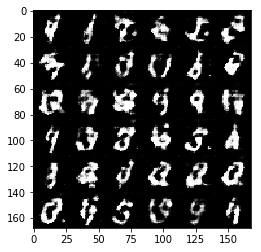

Epoch 1/2;   Batch: 310;   Discriminator Loss: 1.5594;   Generator Loss: 0.4842
Epoch 1/2;   Batch: 320;   Discriminator Loss: 0.9183;   Generator Loss: 1.1292
Epoch 1/2;   Batch: 330;   Discriminator Loss: 1.1592;   Generator Loss: 1.7610
Epoch 1/2;   Batch: 340;   Discriminator Loss: 1.3619;   Generator Loss: 0.9653
Epoch 1/2;   Batch: 350;   Discriminator Loss: 0.9113;   Generator Loss: 1.0968
Epoch 1/2;   Batch: 360;   Discriminator Loss: 0.9247;   Generator Loss: 1.9340
Epoch 1/2;   Batch: 370;   Discriminator Loss: 1.6170;   Generator Loss: 0.3361
Epoch 1/2;   Batch: 380;   Discriminator Loss: 0.9718;   Generator Loss: 1.3379
Epoch 1/2;   Batch: 390;   Discriminator Loss: 1.2780;   Generator Loss: 0.6157
Epoch 1/2;   Batch: 400;   Discriminator Loss: 1.2728;   Generator Loss: 0.4717


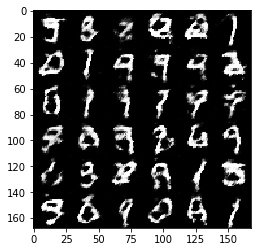

Epoch 1/2;   Batch: 410;   Discriminator Loss: 1.0329;   Generator Loss: 0.9746
Epoch 1/2;   Batch: 420;   Discriminator Loss: 1.1572;   Generator Loss: 1.7032
Epoch 1/2;   Batch: 430;   Discriminator Loss: 1.5349;   Generator Loss: 0.4794
Epoch 1/2;   Batch: 440;   Discriminator Loss: 0.8925;   Generator Loss: 1.2874
Epoch 1/2;   Batch: 450;   Discriminator Loss: 1.1542;   Generator Loss: 0.5641
Epoch 1/2;   Batch: 460;   Discriminator Loss: 1.5525;   Generator Loss: 0.3519
Epoch 2/2;   Batch: 0;   Discriminator Loss: 1.3021;   Generator Loss: 0.7999


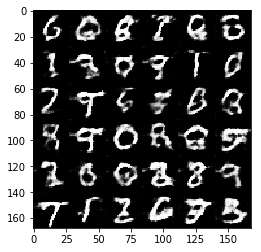

Epoch 2/2;   Batch: 10;   Discriminator Loss: 0.9612;   Generator Loss: 0.9901
Epoch 2/2;   Batch: 20;   Discriminator Loss: 1.3267;   Generator Loss: 1.4876
Epoch 2/2;   Batch: 30;   Discriminator Loss: 1.1872;   Generator Loss: 0.7394
Epoch 2/2;   Batch: 40;   Discriminator Loss: 0.9764;   Generator Loss: 1.8829
Epoch 2/2;   Batch: 50;   Discriminator Loss: 1.2910;   Generator Loss: 1.4991
Epoch 2/2;   Batch: 60;   Discriminator Loss: 1.2211;   Generator Loss: 1.1108
Epoch 2/2;   Batch: 70;   Discriminator Loss: 0.9027;   Generator Loss: 1.1437
Epoch 2/2;   Batch: 80;   Discriminator Loss: 1.3212;   Generator Loss: 0.6513
Epoch 2/2;   Batch: 90;   Discriminator Loss: 1.2669;   Generator Loss: 0.8020
Epoch 2/2;   Batch: 100;   Discriminator Loss: 1.0859;   Generator Loss: 0.9239


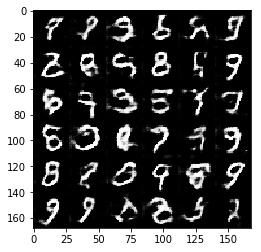

Epoch 2/2;   Batch: 110;   Discriminator Loss: 1.2586;   Generator Loss: 0.7988
Epoch 2/2;   Batch: 120;   Discriminator Loss: 0.9589;   Generator Loss: 0.8513
Epoch 2/2;   Batch: 130;   Discriminator Loss: 1.0676;   Generator Loss: 1.2971
Epoch 2/2;   Batch: 140;   Discriminator Loss: 1.1223;   Generator Loss: 0.6910
Epoch 2/2;   Batch: 150;   Discriminator Loss: 1.3294;   Generator Loss: 1.2509
Epoch 2/2;   Batch: 160;   Discriminator Loss: 1.1782;   Generator Loss: 0.9282
Epoch 2/2;   Batch: 170;   Discriminator Loss: 1.3207;   Generator Loss: 1.5340
Epoch 2/2;   Batch: 180;   Discriminator Loss: 1.0636;   Generator Loss: 1.2736
Epoch 2/2;   Batch: 190;   Discriminator Loss: 1.1732;   Generator Loss: 0.8075
Epoch 2/2;   Batch: 200;   Discriminator Loss: 1.2502;   Generator Loss: 0.7109


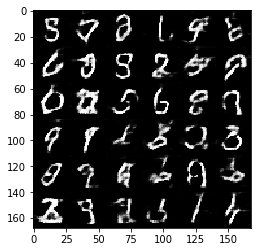

Epoch 2/2;   Batch: 210;   Discriminator Loss: 1.1431;   Generator Loss: 0.8051
Epoch 2/2;   Batch: 220;   Discriminator Loss: 1.2049;   Generator Loss: 0.8009
Epoch 2/2;   Batch: 230;   Discriminator Loss: 1.4677;   Generator Loss: 0.7164
Epoch 2/2;   Batch: 240;   Discriminator Loss: 1.3747;   Generator Loss: 0.5566
Epoch 2/2;   Batch: 250;   Discriminator Loss: 1.0406;   Generator Loss: 0.8462
Epoch 2/2;   Batch: 260;   Discriminator Loss: 1.3448;   Generator Loss: 0.5128
Epoch 2/2;   Batch: 270;   Discriminator Loss: 1.2242;   Generator Loss: 0.6709
Epoch 2/2;   Batch: 280;   Discriminator Loss: 1.1739;   Generator Loss: 1.3631
Epoch 2/2;   Batch: 290;   Discriminator Loss: 1.0924;   Generator Loss: 1.0288
Epoch 2/2;   Batch: 300;   Discriminator Loss: 2.0683;   Generator Loss: 3.1648


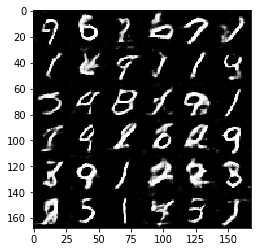

Epoch 2/2;   Batch: 310;   Discriminator Loss: 1.2449;   Generator Loss: 0.8828
Epoch 2/2;   Batch: 320;   Discriminator Loss: 1.0673;   Generator Loss: 0.9481
Epoch 2/2;   Batch: 330;   Discriminator Loss: 1.1689;   Generator Loss: 0.6651
Epoch 2/2;   Batch: 340;   Discriminator Loss: 1.1353;   Generator Loss: 1.0428
Epoch 2/2;   Batch: 350;   Discriminator Loss: 1.6266;   Generator Loss: 0.4583
Epoch 2/2;   Batch: 360;   Discriminator Loss: 1.2124;   Generator Loss: 0.9082
Epoch 2/2;   Batch: 370;   Discriminator Loss: 1.3494;   Generator Loss: 0.5016
Epoch 2/2;   Batch: 380;   Discriminator Loss: 1.1105;   Generator Loss: 0.7897
Epoch 2/2;   Batch: 390;   Discriminator Loss: 1.2284;   Generator Loss: 0.9431
Epoch 2/2;   Batch: 400;   Discriminator Loss: 1.2481;   Generator Loss: 1.0165


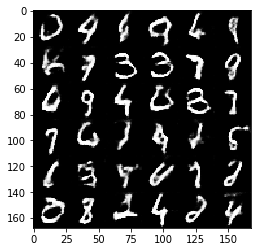

Epoch 2/2;   Batch: 410;   Discriminator Loss: 1.1399;   Generator Loss: 0.7613
Epoch 2/2;   Batch: 420;   Discriminator Loss: 1.2228;   Generator Loss: 0.7534
Epoch 2/2;   Batch: 430;   Discriminator Loss: 1.8055;   Generator Loss: 0.2546
Epoch 2/2;   Batch: 440;   Discriminator Loss: 1.0688;   Generator Loss: 1.1454
Epoch 2/2;   Batch: 450;   Discriminator Loss: 1.3046;   Generator Loss: 0.5516
Epoch 2/2;   Batch: 460;   Discriminator Loss: 1.1565;   Generator Loss: 0.9416


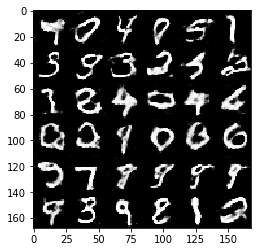

In [12]:
batch_size = 128
z_dim = 100
# Simple data set so start with a higher learning rate
learning_rate = 0.002
# High values of beta1 caused the generator loss to be a lot higher.
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1;   Batch: 0;   Discriminator Loss: 8.4579;   Generator Loss: 0.0003


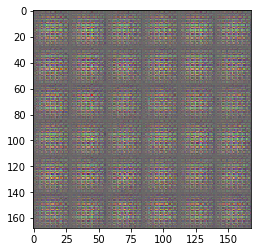

Epoch 1/1;   Batch: 10;   Discriminator Loss: 2.8138;   Generator Loss: 0.0881
Epoch 1/1;   Batch: 20;   Discriminator Loss: 1.6958;   Generator Loss: 0.2257
Epoch 1/1;   Batch: 30;   Discriminator Loss: 0.7223;   Generator Loss: 0.8014
Epoch 1/1;   Batch: 40;   Discriminator Loss: 0.1540;   Generator Loss: 3.3702
Epoch 1/1;   Batch: 50;   Discriminator Loss: 2.0233;   Generator Loss: 15.7250
Epoch 1/1;   Batch: 60;   Discriminator Loss: 0.1245;   Generator Loss: 6.1087
Epoch 1/1;   Batch: 70;   Discriminator Loss: 1.0509;   Generator Loss: 8.8135
Epoch 1/1;   Batch: 80;   Discriminator Loss: 1.2341;   Generator Loss: 0.5622
Epoch 1/1;   Batch: 90;   Discriminator Loss: 1.1831;   Generator Loss: 6.1987
Epoch 1/1;   Batch: 100;   Discriminator Loss: 0.8205;   Generator Loss: 0.8747


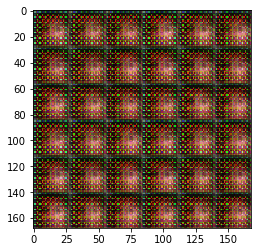

Epoch 1/1;   Batch: 110;   Discriminator Loss: 0.4571;   Generator Loss: 2.0804
Epoch 1/1;   Batch: 120;   Discriminator Loss: 0.2833;   Generator Loss: 2.5690
Epoch 1/1;   Batch: 130;   Discriminator Loss: 0.3042;   Generator Loss: 2.3264
Epoch 1/1;   Batch: 140;   Discriminator Loss: 0.3917;   Generator Loss: 1.8476
Epoch 1/1;   Batch: 150;   Discriminator Loss: 0.1961;   Generator Loss: 2.5754
Epoch 1/1;   Batch: 160;   Discriminator Loss: 0.2283;   Generator Loss: 2.8420
Epoch 1/1;   Batch: 170;   Discriminator Loss: 0.1467;   Generator Loss: 2.8799
Epoch 1/1;   Batch: 180;   Discriminator Loss: 0.5442;   Generator Loss: 2.0071
Epoch 1/1;   Batch: 190;   Discriminator Loss: 1.4913;   Generator Loss: 0.3293
Epoch 1/1;   Batch: 200;   Discriminator Loss: 1.5487;   Generator Loss: 4.5478


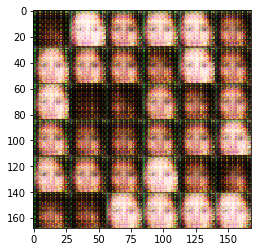

Epoch 1/1;   Batch: 210;   Discriminator Loss: 0.8216;   Generator Loss: 1.6383
Epoch 1/1;   Batch: 220;   Discriminator Loss: 0.5655;   Generator Loss: 3.7254
Epoch 1/1;   Batch: 230;   Discriminator Loss: 1.0614;   Generator Loss: 0.6748
Epoch 1/1;   Batch: 240;   Discriminator Loss: 0.9792;   Generator Loss: 0.9467
Epoch 1/1;   Batch: 250;   Discriminator Loss: 0.8435;   Generator Loss: 0.7689
Epoch 1/1;   Batch: 260;   Discriminator Loss: 0.6610;   Generator Loss: 2.6743
Epoch 1/1;   Batch: 270;   Discriminator Loss: 0.5142;   Generator Loss: 1.6605
Epoch 1/1;   Batch: 280;   Discriminator Loss: 0.8502;   Generator Loss: 1.0760
Epoch 1/1;   Batch: 290;   Discriminator Loss: 1.0530;   Generator Loss: 0.7494
Epoch 1/1;   Batch: 300;   Discriminator Loss: 0.7116;   Generator Loss: 0.9503


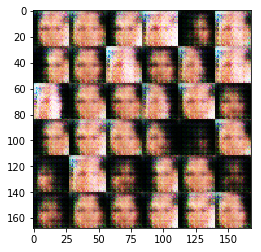

Epoch 1/1;   Batch: 310;   Discriminator Loss: 2.6193;   Generator Loss: 8.2328
Epoch 1/1;   Batch: 320;   Discriminator Loss: 0.5193;   Generator Loss: 1.6886
Epoch 1/1;   Batch: 330;   Discriminator Loss: 0.6467;   Generator Loss: 1.3454
Epoch 1/1;   Batch: 340;   Discriminator Loss: 1.6140;   Generator Loss: 5.0818
Epoch 1/1;   Batch: 350;   Discriminator Loss: 0.8905;   Generator Loss: 1.0526
Epoch 1/1;   Batch: 360;   Discriminator Loss: 0.7694;   Generator Loss: 1.0861
Epoch 1/1;   Batch: 370;   Discriminator Loss: 0.5379;   Generator Loss: 1.9659
Epoch 1/1;   Batch: 380;   Discriminator Loss: 0.5697;   Generator Loss: 1.6208
Epoch 1/1;   Batch: 390;   Discriminator Loss: 0.5186;   Generator Loss: 1.7618
Epoch 1/1;   Batch: 400;   Discriminator Loss: 0.6968;   Generator Loss: 2.4130


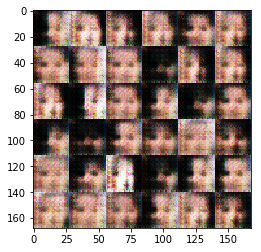

Epoch 1/1;   Batch: 410;   Discriminator Loss: 0.5648;   Generator Loss: 2.0064
Epoch 1/1;   Batch: 420;   Discriminator Loss: 0.4746;   Generator Loss: 1.8582
Epoch 1/1;   Batch: 430;   Discriminator Loss: 1.3790;   Generator Loss: 0.4426
Epoch 1/1;   Batch: 440;   Discriminator Loss: 0.5965;   Generator Loss: 1.9258
Epoch 1/1;   Batch: 450;   Discriminator Loss: 1.3694;   Generator Loss: 3.2417
Epoch 1/1;   Batch: 460;   Discriminator Loss: 0.7570;   Generator Loss: 1.1704
Epoch 1/1;   Batch: 470;   Discriminator Loss: 0.4521;   Generator Loss: 1.9111
Epoch 1/1;   Batch: 480;   Discriminator Loss: 0.7182;   Generator Loss: 1.4939
Epoch 1/1;   Batch: 490;   Discriminator Loss: 0.8422;   Generator Loss: 0.7888
Epoch 1/1;   Batch: 500;   Discriminator Loss: 0.7804;   Generator Loss: 0.8731


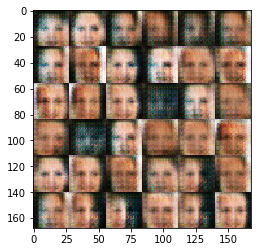

Epoch 1/1;   Batch: 510;   Discriminator Loss: 0.9780;   Generator Loss: 1.6347
Epoch 1/1;   Batch: 520;   Discriminator Loss: 0.6242;   Generator Loss: 1.2481
Epoch 1/1;   Batch: 530;   Discriminator Loss: 0.7324;   Generator Loss: 1.9354
Epoch 1/1;   Batch: 540;   Discriminator Loss: 0.6726;   Generator Loss: 1.7351
Epoch 1/1;   Batch: 550;   Discriminator Loss: 1.1644;   Generator Loss: 0.5697
Epoch 1/1;   Batch: 560;   Discriminator Loss: 0.5057;   Generator Loss: 1.9798
Epoch 1/1;   Batch: 570;   Discriminator Loss: 1.2746;   Generator Loss: 0.6393
Epoch 1/1;   Batch: 580;   Discriminator Loss: 1.0061;   Generator Loss: 1.3096
Epoch 1/1;   Batch: 590;   Discriminator Loss: 1.1007;   Generator Loss: 2.3530
Epoch 1/1;   Batch: 600;   Discriminator Loss: 0.8816;   Generator Loss: 1.3436


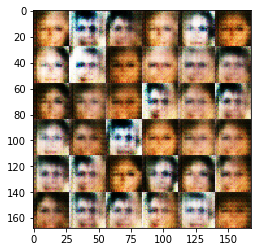

Epoch 1/1;   Batch: 610;   Discriminator Loss: 1.0140;   Generator Loss: 4.8695
Epoch 1/1;   Batch: 620;   Discriminator Loss: 0.8044;   Generator Loss: 1.3748
Epoch 1/1;   Batch: 630;   Discriminator Loss: 0.3975;   Generator Loss: 2.9250
Epoch 1/1;   Batch: 640;   Discriminator Loss: 0.3643;   Generator Loss: 2.0442
Epoch 1/1;   Batch: 650;   Discriminator Loss: 0.7278;   Generator Loss: 1.0691
Epoch 1/1;   Batch: 660;   Discriminator Loss: 4.3640;   Generator Loss: 9.1393
Epoch 1/1;   Batch: 670;   Discriminator Loss: 0.9895;   Generator Loss: 1.8003
Epoch 1/1;   Batch: 680;   Discriminator Loss: 0.8286;   Generator Loss: 1.0989
Epoch 1/1;   Batch: 690;   Discriminator Loss: 0.5883;   Generator Loss: 1.6917
Epoch 1/1;   Batch: 700;   Discriminator Loss: 0.7745;   Generator Loss: 1.7546


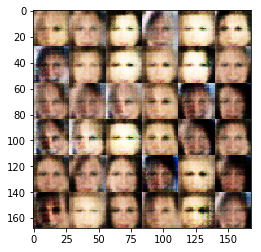

Epoch 1/1;   Batch: 710;   Discriminator Loss: 0.5880;   Generator Loss: 1.4569
Epoch 1/1;   Batch: 720;   Discriminator Loss: 0.8452;   Generator Loss: 2.2180
Epoch 1/1;   Batch: 730;   Discriminator Loss: 0.7673;   Generator Loss: 3.1056
Epoch 1/1;   Batch: 740;   Discriminator Loss: 0.8945;   Generator Loss: 1.3401
Epoch 1/1;   Batch: 750;   Discriminator Loss: 1.0466;   Generator Loss: 0.7120
Epoch 1/1;   Batch: 760;   Discriminator Loss: 1.3251;   Generator Loss: 0.4771
Epoch 1/1;   Batch: 770;   Discriminator Loss: 0.9878;   Generator Loss: 0.8240
Epoch 1/1;   Batch: 780;   Discriminator Loss: 0.7790;   Generator Loss: 2.6924
Epoch 1/1;   Batch: 790;   Discriminator Loss: 0.6025;   Generator Loss: 2.0102
Epoch 1/1;   Batch: 800;   Discriminator Loss: 1.1491;   Generator Loss: 1.9789


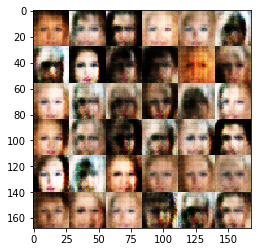

Epoch 1/1;   Batch: 810;   Discriminator Loss: 1.3813;   Generator Loss: 0.4475
Epoch 1/1;   Batch: 820;   Discriminator Loss: 1.0058;   Generator Loss: 0.7922
Epoch 1/1;   Batch: 830;   Discriminator Loss: 0.6927;   Generator Loss: 1.0435
Epoch 1/1;   Batch: 840;   Discriminator Loss: 0.7912;   Generator Loss: 1.9187
Epoch 1/1;   Batch: 850;   Discriminator Loss: 0.5149;   Generator Loss: 2.5591
Epoch 1/1;   Batch: 860;   Discriminator Loss: 0.6594;   Generator Loss: 1.5755
Epoch 1/1;   Batch: 870;   Discriminator Loss: 0.5792;   Generator Loss: 1.6385
Epoch 1/1;   Batch: 880;   Discriminator Loss: 1.2669;   Generator Loss: 1.0346
Epoch 1/1;   Batch: 890;   Discriminator Loss: 2.0631;   Generator Loss: 3.8005
Epoch 1/1;   Batch: 900;   Discriminator Loss: 0.4687;   Generator Loss: 1.8600


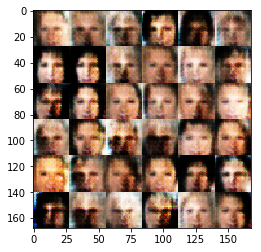

Epoch 1/1;   Batch: 910;   Discriminator Loss: 0.5092;   Generator Loss: 1.9929
Epoch 1/1;   Batch: 920;   Discriminator Loss: 1.2028;   Generator Loss: 0.6108
Epoch 1/1;   Batch: 930;   Discriminator Loss: 0.5980;   Generator Loss: 1.3255
Epoch 1/1;   Batch: 940;   Discriminator Loss: 1.2363;   Generator Loss: 0.5325
Epoch 1/1;   Batch: 950;   Discriminator Loss: 1.4764;   Generator Loss: 0.4512
Epoch 1/1;   Batch: 960;   Discriminator Loss: 1.8025;   Generator Loss: 0.3165
Epoch 1/1;   Batch: 970;   Discriminator Loss: 0.5470;   Generator Loss: 2.2719
Epoch 1/1;   Batch: 980;   Discriminator Loss: 0.5418;   Generator Loss: 1.6431
Epoch 1/1;   Batch: 990;   Discriminator Loss: 0.9425;   Generator Loss: 0.8575
Epoch 1/1;   Batch: 1000;   Discriminator Loss: 0.9031;   Generator Loss: 1.3479


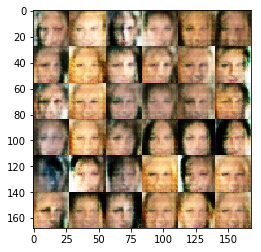

Epoch 1/1;   Batch: 1010;   Discriminator Loss: 0.5171;   Generator Loss: 2.7444
Epoch 1/1;   Batch: 1020;   Discriminator Loss: 1.3154;   Generator Loss: 2.0145
Epoch 1/1;   Batch: 1030;   Discriminator Loss: 0.7510;   Generator Loss: 1.4065
Epoch 1/1;   Batch: 1040;   Discriminator Loss: 0.4863;   Generator Loss: 1.8382
Epoch 1/1;   Batch: 1050;   Discriminator Loss: 0.7904;   Generator Loss: 1.4270
Epoch 1/1;   Batch: 1060;   Discriminator Loss: 0.3127;   Generator Loss: 4.6800
Epoch 1/1;   Batch: 1070;   Discriminator Loss: 0.7667;   Generator Loss: 1.1619
Epoch 1/1;   Batch: 1080;   Discriminator Loss: 1.3180;   Generator Loss: 0.4533
Epoch 1/1;   Batch: 1090;   Discriminator Loss: 0.6036;   Generator Loss: 2.0361
Epoch 1/1;   Batch: 1100;   Discriminator Loss: 1.0161;   Generator Loss: 4.2649


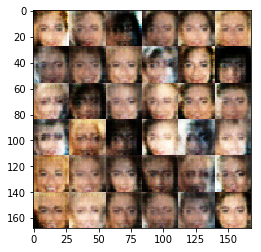

Epoch 1/1;   Batch: 1110;   Discriminator Loss: 1.3318;   Generator Loss: 0.8627
Epoch 1/1;   Batch: 1120;   Discriminator Loss: 0.9825;   Generator Loss: 1.0881
Epoch 1/1;   Batch: 1130;   Discriminator Loss: 0.8548;   Generator Loss: 2.1437
Epoch 1/1;   Batch: 1140;   Discriminator Loss: 0.6888;   Generator Loss: 2.2104
Epoch 1/1;   Batch: 1150;   Discriminator Loss: 2.4023;   Generator Loss: 3.5155
Epoch 1/1;   Batch: 1160;   Discriminator Loss: 1.3964;   Generator Loss: 0.5107
Epoch 1/1;   Batch: 1170;   Discriminator Loss: 1.0718;   Generator Loss: 0.5797
Epoch 1/1;   Batch: 1180;   Discriminator Loss: 0.9835;   Generator Loss: 1.6246
Epoch 1/1;   Batch: 1190;   Discriminator Loss: 2.2303;   Generator Loss: 0.1589
Epoch 1/1;   Batch: 1200;   Discriminator Loss: 0.8427;   Generator Loss: 1.4694


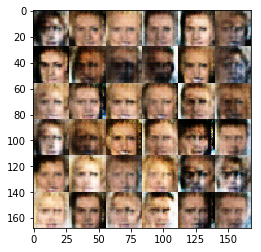

Epoch 1/1;   Batch: 1210;   Discriminator Loss: 1.2490;   Generator Loss: 0.5183
Epoch 1/1;   Batch: 1220;   Discriminator Loss: 0.8765;   Generator Loss: 1.0517
Epoch 1/1;   Batch: 1230;   Discriminator Loss: 0.5700;   Generator Loss: 2.6281
Epoch 1/1;   Batch: 1240;   Discriminator Loss: 0.8304;   Generator Loss: 0.9353
Epoch 1/1;   Batch: 1250;   Discriminator Loss: 1.2011;   Generator Loss: 0.5879
Epoch 1/1;   Batch: 1260;   Discriminator Loss: 0.7172;   Generator Loss: 1.5883
Epoch 1/1;   Batch: 1270;   Discriminator Loss: 0.7467;   Generator Loss: 1.5371
Epoch 1/1;   Batch: 1280;   Discriminator Loss: 0.7106;   Generator Loss: 1.2317
Epoch 1/1;   Batch: 1290;   Discriminator Loss: 0.6950;   Generator Loss: 1.9878
Epoch 1/1;   Batch: 1300;   Discriminator Loss: 2.1825;   Generator Loss: 0.1715


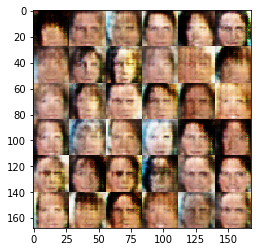

Epoch 1/1;   Batch: 1310;   Discriminator Loss: 1.1915;   Generator Loss: 2.6618
Epoch 1/1;   Batch: 1320;   Discriminator Loss: 1.0888;   Generator Loss: 1.6994
Epoch 1/1;   Batch: 1330;   Discriminator Loss: 0.8958;   Generator Loss: 1.0296
Epoch 1/1;   Batch: 1340;   Discriminator Loss: 1.7078;   Generator Loss: 0.2826
Epoch 1/1;   Batch: 1350;   Discriminator Loss: 0.8750;   Generator Loss: 1.1156
Epoch 1/1;   Batch: 1360;   Discriminator Loss: 0.8752;   Generator Loss: 0.8047
Epoch 1/1;   Batch: 1370;   Discriminator Loss: 1.3812;   Generator Loss: 0.3855
Epoch 1/1;   Batch: 1380;   Discriminator Loss: 0.6668;   Generator Loss: 1.5128
Epoch 1/1;   Batch: 1390;   Discriminator Loss: 1.7948;   Generator Loss: 2.8308
Epoch 1/1;   Batch: 1400;   Discriminator Loss: 0.8377;   Generator Loss: 1.2482


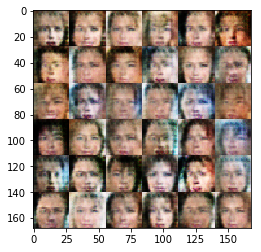

Epoch 1/1;   Batch: 1410;   Discriminator Loss: 0.8296;   Generator Loss: 1.1763
Epoch 1/1;   Batch: 1420;   Discriminator Loss: 1.4522;   Generator Loss: 0.4741
Epoch 1/1;   Batch: 1430;   Discriminator Loss: 0.9156;   Generator Loss: 0.8371
Epoch 1/1;   Batch: 1440;   Discriminator Loss: 0.8847;   Generator Loss: 2.5400
Epoch 1/1;   Batch: 1450;   Discriminator Loss: 0.6133;   Generator Loss: 2.0181
Epoch 1/1;   Batch: 1460;   Discriminator Loss: 1.1121;   Generator Loss: 2.1494
Epoch 1/1;   Batch: 1470;   Discriminator Loss: 1.4525;   Generator Loss: 0.4022
Epoch 1/1;   Batch: 1480;   Discriminator Loss: 0.9146;   Generator Loss: 1.0816
Epoch 1/1;   Batch: 1490;   Discriminator Loss: 0.9296;   Generator Loss: 0.8024
Epoch 1/1;   Batch: 1500;   Discriminator Loss: 0.7801;   Generator Loss: 1.4122


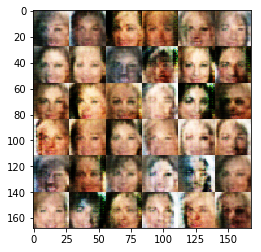

Epoch 1/1;   Batch: 1510;   Discriminator Loss: 0.9223;   Generator Loss: 1.2146
Epoch 1/1;   Batch: 1520;   Discriminator Loss: 1.0176;   Generator Loss: 0.7138
Epoch 1/1;   Batch: 1530;   Discriminator Loss: 0.3558;   Generator Loss: 2.4709
Epoch 1/1;   Batch: 1540;   Discriminator Loss: 1.0424;   Generator Loss: 2.2660
Epoch 1/1;   Batch: 1550;   Discriminator Loss: 1.6497;   Generator Loss: 0.2785
Epoch 1/1;   Batch: 1560;   Discriminator Loss: 1.1307;   Generator Loss: 0.5672
Epoch 1/1;   Batch: 1570;   Discriminator Loss: 0.8873;   Generator Loss: 0.8281
Epoch 1/1;   Batch: 1580;   Discriminator Loss: 0.6043;   Generator Loss: 1.5934


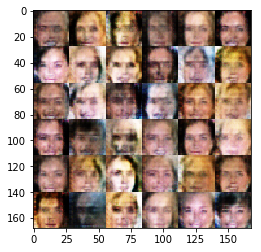

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.